# 1. Load libraries and data

In [1]:
import networkx as nx

import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
%matplotlib inline

import helper

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_trade = helper.clean_trade_quantities(pd.read_pickle("../data/df_trade.pkl"))

In [3]:
df_trade

,Importer,Exporter,Item,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,Argentina,Maize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,Azerbaijan,Tea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,Afghanistan,Azerbaijan,Wheat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,Bangladesh,Jute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,111.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,Belgium,Cotton lint,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446420,Yemen,Zimbabwe,Maize,0.0,0.0,0.0,27007.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446421,Zambia,Zimbabwe,Papayas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446422,Zambia,Zimbabwe,Plantains and others,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,95.0,0.0
446423,Zambia,Zimbabwe,"Pumpkins, squash and gourds",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
df_pop = pd.read_csv("../data/worldbank_pop_data.csv", skiprows=4)
drop_columns = ['Country Code', 'Indicator Name', 'Indicator Code', '2019', 'Unnamed: 64'] + \
                [str(year) for year in range(1960, 1993)]
df_pop = df_pop.drop(columns=drop_columns)
df_pop = df_pop.rename(columns={'Country Name': 'Country'})
df_pop.reset_index(drop=True,inplace=True)
df_pop = df_pop.set_index(['Country'])

In [71]:
df_pop

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,,,,,,,,,,,,,
Aruba,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,...,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0
Afghanistan,15816603.0,17075727.0,18110657.0,18853437.0,19357126.0,19737765.0,20170844.0,20779953.0,21606988.0,22600770.0,...,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
Angola,13075049.0,13503747.0,13945206.0,14400719.0,14871570.0,15359601.0,15866869.0,16395473.0,16945753.0,17519417.0,...,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0
Albania,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
Andorra,60971.0,62677.0,63850.0,64360.0,64327.0,64142.0,64370.0,65390.0,67341.0,70049.0,...,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,1965000.0,1997000.0,2029000.0,2059000.0,2086000.0,1966000.0,1762000.0,1700000.0,1701154.0,1702310.0,...,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0,1845300.0
"Yemen, Rep.",13634076.0,14297613.0,14913315.0,15469274.0,15975668.0,16450310.0,16921149.0,17409072.0,17918373.0,18443691.0,...,22516460.0,23154855.0,23807588.0,24473178.0,25147109.0,25823485.0,26497889.0,27168210.0,27834821.0,28498687.0
South Africa,39633750.0,40564059.0,41435758.0,42241011.0,42987461.0,43682260.0,44338543.0,44967708.0,45571274.0,46150913.0,...,50477011.0,51216964.0,52004172.0,52834005.0,53689236.0,54545991.0,55386367.0,56203654.0,57000451.0,57779622.0


In [59]:
country_groups = pd.read_csv('../data/FAOSTAT_data_11-19-2019.csv')

In [60]:
country_groups

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT
...,...,...,...,...,...,...,...
1848,5000,World,246,Yemen Ar Rp,886.0,NaN,NaN
1849,5000,World,247,Yemen Dem,720.0,NaN,NaN
1850,5000,World,248,Yugoslav SFR,890.0,NaN,NaN
1851,5000,World,251,Zambia,894.0,ZM,ZMB


# 2. Graphs

## 2.1 Helper functions

In [4]:
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [35]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o', width=1.0):
    plt.figure(figsize=(13,13)) 
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha, width=width)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [6]:
def replace_country(country, replacements, replacements_names):
    for i, replacement in enumerate(replacements):
        if country in replacement:
            return replacements_names[i]

In [44]:
def region_continent_pipeline(replacements, replacements_names, directed=False):
    df_trade_grouped = df_trade_unweighted.copy()

    for i, row in df_trade_grouped.iterrows():
        row.Exporter = replace_country(row['Exporter'], replacements, replacements_names)
        row.Importer = replace_country(row['Importer'], replacements, replacements_names)

    df_trade_grouped = df_trade_grouped.groupby(['Exporter', 'Importer']) \
                                                                   .size() \
                                                                   .to_frame('Count') \
                                                                   .reset_index()
    nx_grouped = nx.from_pandas_edgelist(df_trade_grouped, 'Exporter', 'Importer', \
                                                       edge_attr='Count', create_using=nx.DiGraph() if directed \
                                                                                    else nx.Graph())
    
    max_counts = np.max(df_trade_grouped['Count'].values)
    counts = [nx_grouped[u][v]['Count']/max_counts for u,v in nx_grouped.edges()]
    
    if directed:
        print(nx.info(nx_grouped))
    else:
        describe_graph(nx_undirected_grouped)
    
    visualize_graph(nx_grouped, with_labels=True, k=0.05, alpha=0.8, width=counts)
    
    return df_trade_grouped, nx_grouped

In [19]:
def check_connectedness(nx_graph):
    print(nx.is_connected(nx_graph))
    comp = list(nx.connected_components(nx_graph))
    print('The graph contains', len(comp), 'connected components')
    largest_comp = max(comp, key=len)
    percentage_lcc = len(largest_comp)/nx_graph.number_of_nodes() * 100
    print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')

In [34]:
def rank_degree_undirected(nx_graph):
    degrees = dict(nx_graph.degree(nx_graph.nodes()))
    sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
    for node, degree in sorted_degree:
        print(node, 'has connection with', degree, 'other nodes.')

In [87]:
def rank_degree_directed(nx_graph):
    in_degrees = dict(nx_graph.in_degree(nx_graph.nodes()))
    sorted_in_degree = sorted(in_degrees.items(), key=itemgetter(1), reverse=True)
    out_degrees = dict(nx_graph.out_degree(nx_graph.nodes()))
    sorted__out_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
    for node, degree in sorted_degree:
        print(node, "has in-degree of", degree)
    for node, degree in sorted_degree:
        print(node, "has out-degree of", degree)

In [103]:
def region_continent_weighted_pipeline(replacements, replacements_names, year, directed=False):
    df_trade_grouped_weighted = df_trade.copy()
    df_trade_grouped_weighted = df_trade_grouped_weighted.groupby(['Exporter', 'Importer']).sum().reset_index()

    for i, row in df_trade_grouped_weighted.iterrows():
        df_trade_grouped_weighted.loc[i, 'Exporter'] = replace_country(row['Exporter'], continents, continent_names)
        df_trade_grouped_weighted.loc[i, 'Importer'] = replace_country(row['Importer'], continents, continent_names)
        
    df_trade_grouped_weighted = df_trade_continent_weighted.groupby(['Exporter', 'Importer']) \
                                                           .sum() \
                                                           .reset_index()[['Exporter', 'Importer', year]]
    
    nx_grouped_weighted = nx.from_pandas_edgelist(df_trade_grouped_weighted, 'Exporter', 'Importer', \
                                         edge_attr=year, create_using=nx.DiGraph() if directed else nx.Graph())
    
    max_counts = np.max(df_trade_grouped_weighted[year].values)
    counts = [nx_grouped_weighted[u][v][year]/max_counts for u,v in nx_grouped_weighted.edges()]
    
    if directed:
        print(nx.info(nx_grouped_weighted))
    else:
        describe_graph(nx_grouped_weighted)
    
    visualize_graph(nx_grouped_weighted, with_labels=True, k=0.05, alpha=0.8, width=counts)
    
    return df_trade_grouped_weighted, nx_grouped_weighted

## 2.2 Network graphs that don't take into account traded quantities

### 2.2.1 Global

In [8]:
df_trade_unweighted = df_trade[['Importer', 'Exporter']].drop_duplicates()

In [9]:
nx_unweighted = nx.from_pandas_edgelist(df_trade_unweighted, 'Exporter', 'Importer', edge_attr=None, create_using= nx.Graph())

In [10]:
describe_graph(nx_unweighted)

Name: 
Type: Graph
Number of nodes: 213
Number of edges: 14863
Average degree: 139.5587
Avg. Shortest Path Length: 1.3456
Diameter: 2.0000
Sparsity: 0.6583
Global clustering coefficient aka Transitivity: 0.7949


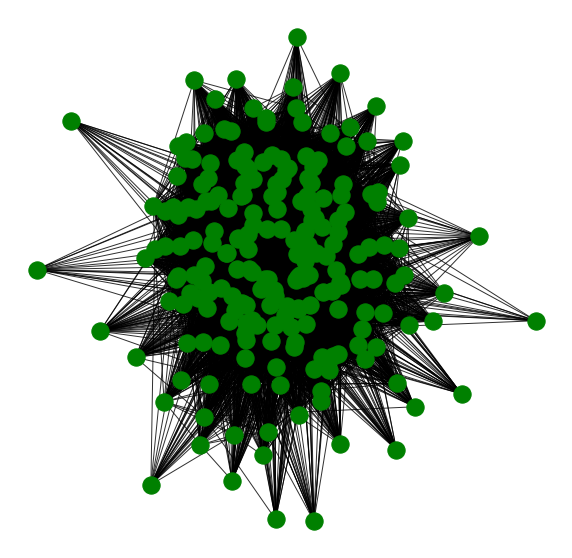

In [11]:
visualize_graph(nx_unweighted, with_labels=False, k=0.05, alpha=0.8)

We can see that the graph is not really understandable because of all the edges. Indeed, the average degree of a node is 139.5 so, on average, every country trades with almost 140 other countries. Therefore, we're going to focus our analysis on continents and regions instead.

### 2.2.2 Continents

In [13]:
african_countries = set(country_groups[country_groups['Country Group'] == 'Africa']['Country'])
american_countries = set(country_groups[country_groups['Country Group'] == 'Americas']['Country'])
asian_countries = set(country_groups[country_groups['Country Group'] == 'Asia']['Country'])
european_countries = set(country_groups[country_groups['Country Group'] == 'Europe']['Country'])
oceanian_countries = set(country_groups[country_groups['Country Group'] == 'Oceania']['Country'])

continents = [african_countries, american_countries, asian_countries, european_countries, oceanian_countries]
continent_names = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 15
Average degree:   6.0000
Avg. Shortest Path Length: 1.0000
Diameter: 1.0000
Sparsity: 1.5000
Global clustering coefficient aka Transitivity: 1.0000


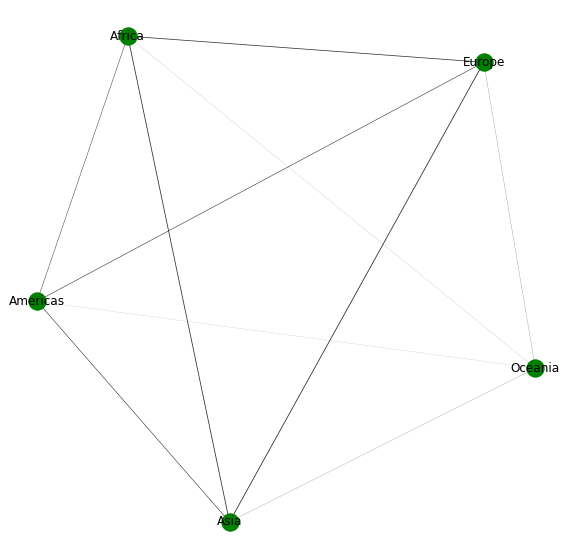

In [16]:
df_trade_continents, nx_undirected_continents = region_continent_pipeline(continents, continent_names)

In [20]:
check_connectedness(nx_undirected_continents)

True
The graph contains 1 connected components
The largest component has 5 nodes accounting for 100.00 % of the nodes


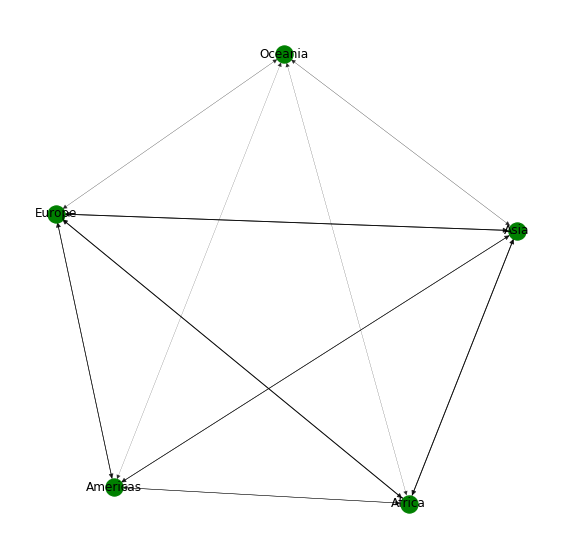

In [32]:
df_trade_continents, nx_directed_continents = region_continent_pipeline(continents, continent_names, directed=True)

### 2.2.3 Regions

In [17]:
region_names = ['Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa',
                'Northern America', 'Central America', 'Caribbean', 'South America',
                'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-Eastern Asia', 'Western Asia',
                'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe',
                'Australia and New Zealand', 'Melanesia', 'Polynesia']
regions = [set(country_groups[country_groups['Country Group'] == region]['Country']) for region in region_names]

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 231
Average degree:  22.0000
Avg. Shortest Path Length: 1.0000
Diameter: 1.0000
Sparsity: 1.1000
Global clustering coefficient aka Transitivity: 1.0000


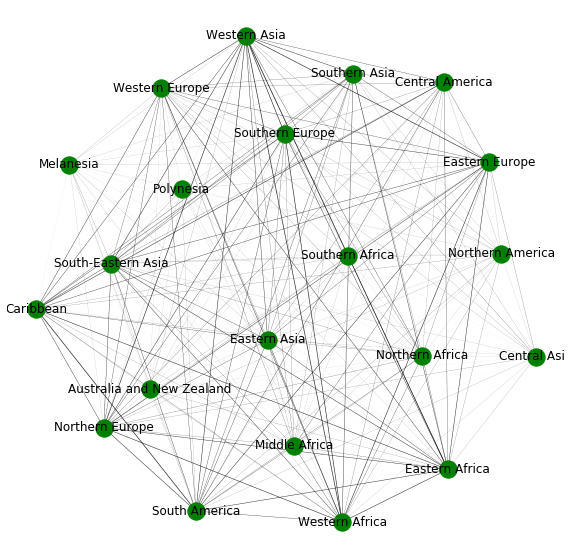

In [18]:
df_trade_regions, nx_undirected_regions = region_continent_pipeline(regions, region_names)

In [21]:
check_connectedness(nx_undirected_regions)

True
The graph contains 1 connected components
The largest component has 21 nodes accounting for 100.00 % of the nodes


Name: 
Type: DiGraph
Number of nodes: 21
Number of edges: 441
Average in degree:  21.0000
Average out degree:  21.0000


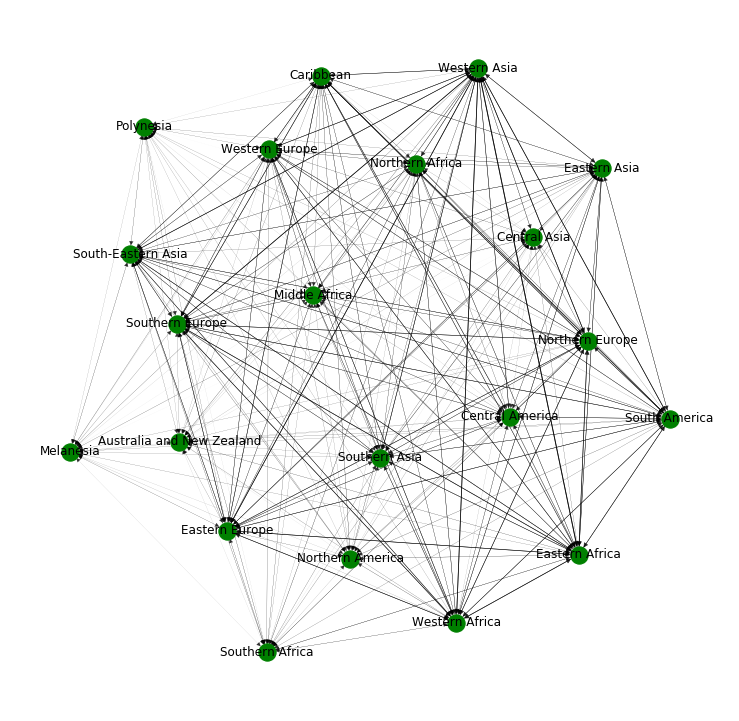

In [38]:
df_trade_regions, nx_directed_regions = region_continent_pipeline(regions, region_names, directed=True)

In [42]:
nx_directed_regions.number_of_selfloops()

21

## 2.3 Network graphs with traded quantities

### 2.3.1 Continents

In [82]:
df_pop_continent = df_pop.copy()
for i, row in df_pop_continent.iterrows():
    df_pop_continent.loc[i, 'Continent'] = replace_country(i, continents, continent_names)
df_pop_continent = df_pop_continent.groupby(['Continent']).sum()

Name: 
Type: DiGraph
Number of nodes: 5
Number of edges: 25
Average in degree:   5.0000
Average out degree:   5.0000


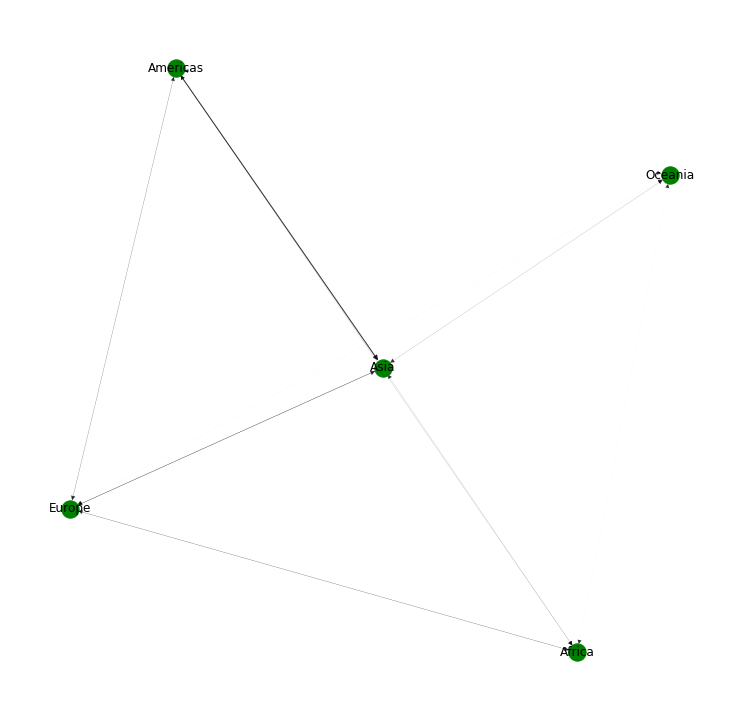

In [105]:
df_trade_continent_weighted, nx_continent_weighted = region_continent_weighted_pipeline(continents, continent_names, "2015", directed=True)